In [8]:
# !pip install scikit-image

In [9]:
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# For superpixel segmentation
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [10]:
%matplotlib inline

# Helper Functions

In [11]:
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:
# 디바이스 선택: GPU가 사용 가능하면 GPU 사용, 그렇지 않으면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2) Helper: URL에서 이미지 로드
############################################
def load_image_from_url(url):
    """
    URL에서 이미지를 로드하고 PIL Image로 반환합니다.
    """
    response = requests.get(url)
    pil_img = Image.open(BytesIO(response.content)).convert("RGB")
    return pil_img

In [ ]:
# 1. SLIC를 사용하여 이미지를 superpixel로 분할합니다.

def segment_image(image, n_segments=200):
    """
    이미지를 superpixel로 분할합니다.
    :param image: RGB 형식의 NumPy 배열 (H, W, 3)로 된 입력 이미지.
    :param n_segments: 원하는 superpixel의 개수.
    :return: segmentation label 배열.
    """
    segments = slic(image, n_segments=n_segments, compactness=5, sigma=1, start_label=0)
    return segments

In [ ]:
# 2. binary mask가 주어진 경우 이미지를 perturb합니다.
def perturb_image(image, segments, binary_mask, hide_color=None):
    """
    "off"로 설정된 세그먼트(binary_mask==0)의 픽셀을 hide_color로 교체합니다.
    :param image: NumPy 배열로 된 원본 이미지.
    :param segments: 각 픽셀의 segmentation label.
    :param binary_mask: 1D 배열 (길이 = 세그먼트 개수), 1=유지, 0=숨김.
    :param hide_color: 숨겨진 영역에 사용할 색상; None이면 전역 평균을 사용합니다.
    :return: NumPy 배열로 된 perturbed 이미지.
    :param hide_color: hide_color 파라미터는 superpixel의 모든 픽셀을 특정한 균일한 색상으로 교체하여 superpixel을 "숨기는" 데 사용됩니다. 이렇게 하면 superpixel이 이미지에서 효과적으로 사라져, 분류기가 perturbed 이미지를 처리할 때 일관된 baseline을 제공합니다.
    """
    if hide_color is None:
        # Compute global mean color (per channel)
        hide_color = np.mean(image, axis=(0, 1)).astype(image.dtype)
    perturbed = image.copy()
    for seg_val in np.unique(segments):
        if binary_mask[int(seg_val)] == 0:
            perturbed[segments == seg_val] = hide_color
    return perturbed

In [ ]:
# 3. superpixel에 대한 여러 perturbed sample(binary vector)을 생성합니다.

def generate_perturbed_samples(num_segments, num_samples=1000, random_state=None):
    """
    어떤 superpixel이 유지되는지를 나타내는 binary vector 집합을 생성합니다.
    원본 이미지는 모든 원소가 1인 vector에 해당합니다.
    :param num_segments: superpixel의 개수.
    :param num_samples: 총 sample 개수 (원본 포함).
    :param random_state: 재현성을 위한 선택적 정수.
    :return: shape (num_samples, num_segments)의 배열.
    """
    rng = np.random.RandomState(random_state) # 재현성을 위해

    # binary vector를 담을 sample 배열
    # 각 행은 하나의 sample에 해당하고, 각 열은 하나의 superpixel에 해당합니다.
    samples = []

    # 원본 인스턴스(모두 1)가 첫 번째 sample이 되도록 보장합니다.
    # 원본 이미지는 모든 superpixel을 포함하므로 모두 1입니다.
    samples.append(np.ones(num_segments, dtype=int))
    
    # 첫 번째 원본 이미지를 제외하고, 나머지 sample을 생성하기 위해 n-1번 반복합니다.
    # 각 superpixel에 대해 binomial 분포에서 샘플링합니다 (0 또는 1 bernoulli trial).

    # 이 과정은 random binary vector를 생성하는 것입니다.
    for _ in range(num_samples - 1):
        sample = rng.binomial(1, 0.5, size=num_segments)
        samples.append(sample)

    return np.array(samples)

In [ ]:
# 4. 각 perturbed sample에 대한 exponential kernel weight를 계산합니다.

# 논문에서 phi로 표기된 exponential kernel이 필요합니다.
# perturbed 이미지의 weight (원본 이미지와 perturbed 이미지 간의 거리 메트릭을 기반으로 하므로,
# perturbed 이미지가 원본 이미지와 유사할 때 weight가 높고, 원본 이미지에서 멀수록 weight가 낮습니다.)

def compute_kernel_distance(binary_samples, sigma=0.25):
    """
    꺼진 세그먼트의 비율을 기반으로 weight를 계산합니다.
    :param binary_samples: binary vector 배열 (n_samples x num_segments).
    :param sigma: kernel width.
    :return: 1D numpy 배열로 된 weight.
    """
    num_segments = binary_samples.shape[1]
    # Distance is the fraction of segments turned off.
    # Compute the distance as the fraction of segments turned off.
    # A natural choice for the distance D(x, z) is to measure how many superpixels have been “turned off.”
    # Mathematically, if there are d superpixels and a perturbed sample z has ∑z_i ones,
    # then the number of superpixels turned off is d - ∑z_i.
    distances = (num_segments - np.sum(binary_samples, axis=1)) / num_segments
    weights = np.exp(- (distances ** 2) / (sigma ** 2))
    return weights

In [ ]:
# 5. Batch prediction function.

# designed to take a collection of images, process them in a single batch, and return the model’s predicted probabilities for each image



def batch_predict(images, model, transform):
    """
    이미지 리스트/배열(numpy 배열)이 주어지면, 모델을 사용하여 확률을 예측합니다.
    :param images: 이미지의 NumPy 배열 (n_samples, H, W, 3), uint8 형식으로 가정됩니다.
    :param model: 사전 훈련된 PyTorch 모델.
    :param transform: 이미지를 전처리하는 transformation 함수.
    :return: 각 클래스에 대한 예측 확률의 NumPy 배열.
    """

    # dropout과 batch normalization을 비활성화하기 위해 모델을 eval 모드로 설정합니다.
    model.eval()

    # 이미지를 (현재 numpy 배열) PIL Image로 변환
    # transform으로 tensor로 재구성하고, tensor 리스트에 추가합니다.
    tensors = []
    for img in images:
        pil_img = Image.fromarray(img.astype('uint8'))
        tensor = transform(pil_img)
        tensors.append(tensor)

    # tensor 리스트는 torch.stack()을 사용하여 단일 batch로 결합됩니다.
    # 이 함수는 각 tensor를 새로운 차원을 따라 쌓아서 shape (n_samples, C, H, W)의 4D tensor를 만듭니다.
    batch = torch.stack(tensors).to(device)

    # gradient 계산 비활성화 (추론에서는 필요 없음).
    # 단일 forward pass로 전체 batch를 처리합니다.
    with torch.no_grad():
        logits = model(batch)


    probs = torch.nn.functional.softmax(logits, dim=1)
    # dim=1을 따라 계산하는 이유는?
    # 이미지 batch가 있을 때, 예를 들어 shape (batch_size, num_classes)인 경우, dimension 1을 따라 softmax를 적용합니다 (dim=0 : batch_size, 여기서는 1 batch, dim=1 num of classes)
    # 따라서 1 x num_classes tensor가 있습니다
    # softmax 함수는 tensor의 각 행에 적용되어 각 행의 값의 합이 1이 되도록 보장합니다.
    
    return probs.cpu().numpy()

In [ ]:
# 6. Weighted linear regression (intercept 포함).
def weighted_linear_regression(X, y, sample_weights):
    """
    weighted least squares에서 계수를 구합니다:
    w = argmin || sqrt(W) (y - X_design * coef) ||^2.
    X_design은 intercept 열을 포함합니다.
    :param X: shape (n_samples, n_features)의 design matrix.
    :param y: shape (n_samples,)의 target vector.
    :param sample_weights: 각 sample에 대한 weight.
    :return: 계수 vector (첫 번째 원소는 intercept).
    """

    # X : 원본 binary vector matrix (각 행: 1개의 perturbed 이미지, 각 열: 1개의 superpixel)
    # X_design : X에 intercept 열을 추가합니다. 첫 번째 열(모두 1)은 회귀 모델이 intercept를 가질 수 있게 합니다.
    # W : exponential kernel을 사용한 weight로부터의 대각 weight matrix. (원본 이미지와 유사한 perturbed sample에 더 많은 중요성을 부여합니다.)
    # beta: 회귀 계수

    n, d = X.shape
    
    # Step 3: intercept를 포함하고 design matrix를 준비합니다.
    # ---------------------------------------------------------------
    # 원본 binary feature matrix X는 shape (n, d)를 가지며, 여기서:
    #   n = perturbed sample의 개수,
    #   d = superpixel의 개수.
    #
    # 모델에서 intercept를 허용하기 위해 X에 1의 열을 추가합니다.
    # 새로운 matrix X_design은 shape (n, d+1)을 가지며 다음과 같이 정의됩니다:
    #
    #   X_design = [1   X]
    #              [1   X]
    #              ... 
    #
    # 수학적으로, 각 sample i에 대해:
    #   (X_design)_i = [1, x_i1, x_i2, ..., x_id]
    #
    # 이를 통해 로컬 선형 모델이 다음과 같은 형태를 가질 수 있습니다:
    #   f(z_i) ≈ β₀ + β₁*x_i1 + β₂*x_i2 + ... + β_d*x_id
    X_design = np.concatenate([np.ones((n, 1)), X], axis=1)  # X_design: (n, d+1)

    # 그런 다음 weight matrix W를 대각 행렬로 구성합니다.
    # 각 대각 원소 W_ii는 sample i에 대한 weight이며,
    # 이전에 exponential kernel을 사용하여 계산되었습니다:
    #
    #   w_i = exp( - (D(x, z_i)^2) / σ^2 )
    #
    # 여기서 D(x, z_i)는 원본 이미지 x와 perturbed sample z_i 간의 정규화된 거리입니다.
    # 이 matrix W는 x에 가까운 sample(즉, 더 유사한)이 더 높은 영향력을 가지도록 보장합니다.
    W = np.diag(sample_weights)

    # Step 4: β를 찾기 위해 weighted least squares 문제를 해결합니다.
    # ---------------------------------------------------------------
    # 목표는 가중 제곱 오차의 합을 최소화하는 것입니다:
    #
    #   min_β Σᵢ w_i (y_i - (X_design)_i · β)²
    #
    # 행렬 표기법으로 목표를 다음과 같이 씁니다:
    #
    #   min_β || sqrt(W) (y - X_design · β) ||²
    #
    # weighted least squares 해에 대한 normal equation은 다음과 같습니다:
    #
    #   (X_designᵀ W X_design) β = X_designᵀ W y
    #
    # 이 방정식의 좌변(A)과 우변(b)을 계산합니다:
    A = X_design.T @ W @ X_design   # A = X_designᵀ W X_design

    # W가 대각 행렬이므로 W로 곱하는 것은 element-wise 곱셈과 동일합니다:
    b = X_design.T @ (sample_weights * y)  # b = X_designᵀ W y

    # 마지막으로 선형 대수를 사용하여 β(계수, 여기서 β₀는 intercept)를 구합니다:
    coef = np.linalg.solve(A, b)
    return coef

In [ ]:
# 7. 상위 feature를 기반으로 explanation mask를 가져옵니다.
def get_explanation_mask(segments, feature_weights, num_features=5):
    """
    상위 세그먼트에 속한 픽셀을 나타내는 boolean mask를 반환합니다.
    :param segments: segmentation label 배열.
    :param feature_weights: weight 배열 (길이는 세그먼트 개수와 같음).
    :param num_features: 강조할 세그먼트의 개수.
    :return: 선택된 세그먼트의 픽셀에 True인 boolean mask.
    """
    # 가장 높은 양의 기여도를 가진 상위 feature(세그먼트)의 인덱스를 가져옵니다.
    # get_explanation_mask 함수는 상위 기여자를 추출하고 시각화를 위한 mask를 생성하며,
    # 논문의 그림에서 볼 수 있는 주요 영역을 강조하는 개념과 일치합니다.

    # Feature Weight 정렬: 가장 높은 양의 기여도를 가진 superpixel을 식별합니다.
    top_indices = np.argsort(feature_weights)[-num_features:]

    # "mask" 배열 초기화
    mask = np.zeros_like(segments, dtype=bool)

    # 상위 인덱스를 mask에 추가합니다.
    for i in top_indices:
        mask[segments == i] = True
    return mask

# Main Explanation Funciton

In [ ]:
# 11) 메인 "Explain Instance" 함수

def explain_instance(image, model, transform, num_samples=1000, sigma=0.25,
                     n_segments=50, random_state=42, num_features=5):
    """
    LIME과 유사한 접근 방식을 사용하여 최상위 예측 클래스에 대한 로컬 설명을 생성합니다.
    
    단계:
      1) 이미지를 superpixel로 분할합니다.
      2) superpixel의 binary perturbation을 생성합니다.
      3) perturbed 이미지를 생성합니다.
      4) 원본 이미지에서 target class를 식별합니다.
      5) perturbed 이미지에 대한 batch prediction 확률을 계산합니다.
      6) 각 perturbed sample에 대한 kernel weight를 계산합니다.
      7) 모델을 로컬적으로 근사하기 위해 weighted linear regression을 적합시킵니다.
      8) 상위 superpixel을 강조하는 explanation mask를 반환합니다.
    """
    # 이미지 분할
    segments = segment_image(image, n_segments=n_segments)
    num_segments_actual = len(np.unique(segments))
    
    # perturbed binary mask 생성
    binary_samples = generate_perturbed_samples(num_segments_actual, num_samples, random_state)
    
    # binary mask를 기반으로 perturbed 이미지 생성
    perturbed_images = []
    for binary_mask in binary_samples:
        perturbed = perturb_image(image, segments, binary_mask)
        perturbed_images.append(perturbed)
    perturbed_images = np.array(perturbed_images)
    
    # 원본 이미지에 대한 예측으로 target class 식별
    orig_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        orig_logits = model(orig_tensor)
        orig_probs = torch.nn.functional.softmax(orig_logits, dim=1)
    target_class = int(torch.argmax(orig_probs[0]).item())
    
    # 모든 perturbed 이미지에 대한 batch prediction 확률 계산
    preds = batch_predict(perturbed_images, model, transform)
    target_preds = preds[:, target_class]  # target class에 대한 확률 가져오기
    
    # 각 sample에 대한 kernel weight 계산
    weights = compute_kernel_distance(binary_samples, sigma)
    
    # binary feature에 weighted linear regression 적합
    coef = weighted_linear_regression(binary_samples, target_preds, weights)
    intercept = coef[0]
    feature_weights = coef[1:]  # 각 superpixel에 해당하는 계수
    
    # 시각화를 위한 explanation mask 생성 (상위 superpixel 강조)
    explanation_mask = get_explanation_mask(segments, feature_weights, num_features)
    
    # 유용한 모든 정보를 딕셔너리로 반환합니다.
    return {
        "segments": segments,
        "binary_samples": binary_samples,
        "target_preds": target_preds,
        "weights": weights,
        "intercept": intercept,
        "feature_weights": feature_weights,
        "target_class": target_class,
        "explanation_mask": explanation_mask,
    }

In [ ]:
# 12) 모든 것을 통합하기


# 1. 새로운 torchvision API를 사용하여 사전 훈련된 ResNet50 모델을 로드합니다.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.to(device)
model.eval()

# 2. ResNet50을 위한 이미지 전처리를 위한 transformation pipeline을 정의합니다.
transform = transforms.Compose([
    transforms.Resize(256),       # 짧은 쪽을 256 픽셀로 리사이즈
    transforms.CenterCrop(224),   # 224x224로 중앙 crop
    transforms.ToTensor(),        # PIL Image를 Torch tensor로 변환
    transforms.Normalize(         # ImageNet mean과 std를 사용하여 정규화
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# 3. 외부 URL에서 뱀 이미지를 로드합니다.
snake_url = "https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.png?raw=true"
snake_pil = load_image_from_url(snake_url)
snake_np = np.array(snake_pil)  # PIL 이미지를 NumPy 배열로 변환 (H, W, 3)

# 4. 뱀 이미지에 대한 LIME과 유사한 설명을 생성합니다.
explanation = explain_instance(
    image=snake_np,
    model=model,
    transform=transform,
    num_samples=1000,    # 생성할 perturbed sample의 개수
    sigma=0.25,          # weighting을 위한 kernel width
    n_segments=50,       # SLIC를 통한 superpixel의 개수
    random_state=42,     # 재현성을 위해
    num_features=5       # 설명에서 강조할 상위 superpixel의 개수
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:05<00:00, 17.9MB/s]


In [ ]:
# 5. 뱀 이미지에 대한 예측 클래스를 출력합니다.
predicted_class = explanation["target_class"]
print("Predicted Class Index:", predicted_class)
print("Predicted Class Label:", classes[predicted_class])


Predicted Class Index: 56
Predicted Class Label: king snake


In [ ]:
# 6. Debug: 상위 superpixel 인덱스와 해당 weight를 출력합니다.
feature_weights = explanation["feature_weights"]
top_superpixels = np.argsort(feature_weights)[-5:]
print("\nTop 5 superpixel indices:", top_superpixels)
print("Corresponding weights:", feature_weights[top_superpixels])


Top 5 superpixel indices: [ 1  9  7 13  6]
Corresponding weights: [0.00958122 0.01170547 0.01204737 0.01557134 0.10844986]


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

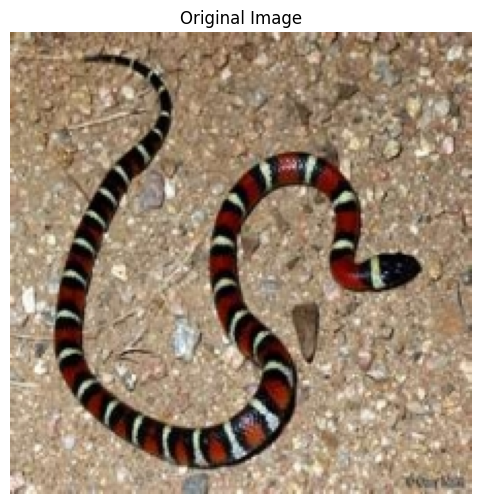

In [ ]:
# 7. 설명을 시각화합니다.
fig, ax = plt.subplots(figsize=(8, 6))

# 원본 뱀 이미지를 표시합니다.
ax.imshow(snake_np)
ax.set_title("Original Image")
ax.axis("off")


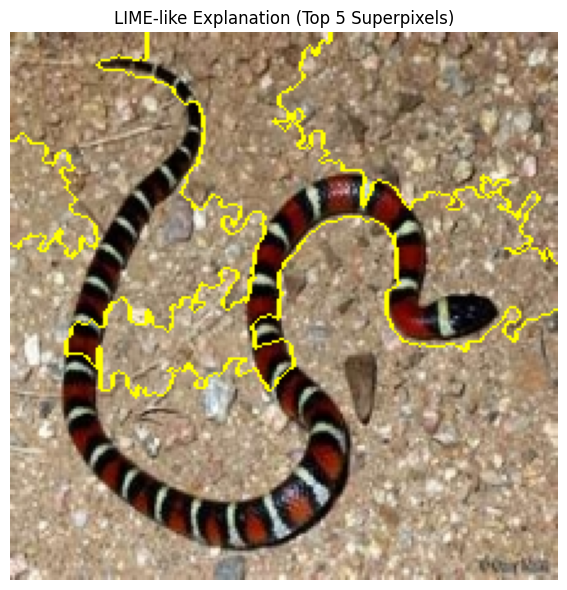

In [ ]:
%matplotlib inline

# 두 개의 subplot이 있는 figure 생성
fig, ax = plt.subplots(figsize=(8, 6))
# explanation mask를 오버레이합니다 (상위 superpixel의 경계를 강조).
explanation_mask = explanation["explanation_mask"]
ax.imshow(mark_boundaries(snake_np, explanation_mask.astype(int)))
ax.set_title("LIME-like Explanation (Top 5 Superpixels)")
ax.axis("off")

plt.tight_layout()
plt.show()

# Debug

In [27]:
print("Segments shape:", explanation["segments"].shape)
print("Unique segment labels:", np.unique(explanation["segments"]))


Segments shape: (224, 224)
Unique segment labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [28]:
print("Explanation mask shape:", explanation["explanation_mask"].shape)
print("Mask unique values:", np.unique(explanation["explanation_mask"]))


Explanation mask shape: (224, 224)
Mask unique values: [False  True]


In [29]:
feature_weights = explanation["feature_weights"]
top_superpixels = np.argsort(feature_weights)[-5:]
print("Top superpixels:", top_superpixels)
print("Weights of top superpixels:", feature_weights[top_superpixels])


Top superpixels: [ 1  9  7 13  6]
Weights of top superpixels: [0.00958122 0.01170547 0.01204737 0.01557134 0.10844986]


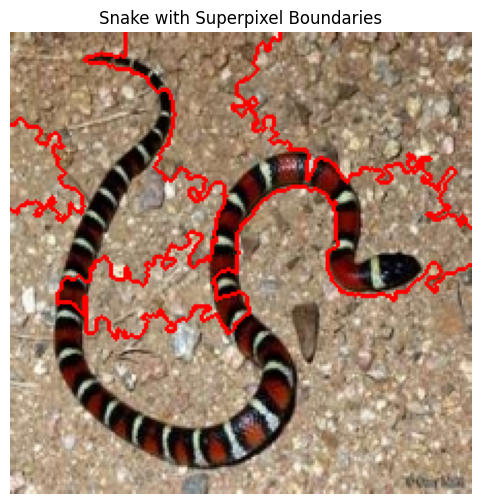

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# 두 개의 subplot이 있는 figure 생성
fig, ax = plt.subplots(figsize=(8, 6))

# 윤곽선 두께를 증가시키거나 색상을 변경합니다:
ax.imshow(mark_boundaries(
    snake_np, 
    explanation["explanation_mask"].astype(int),
    color=(1, 0, 0),       # 녹색 대신 빨간색 경계
    mode='thick'           # 더 두꺼운 경계
))

ax.set_title("Snake with Superpixel Boundaries")
ax.axis("off")  # 축 숨기기
plt.show()

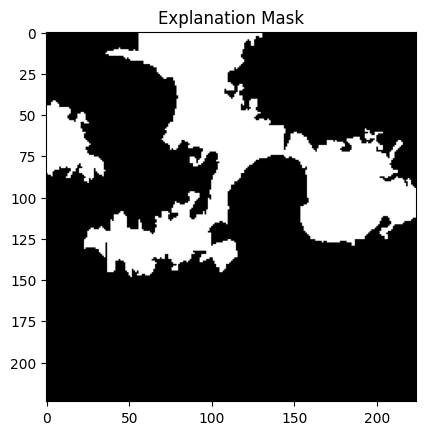

In [31]:
plt.imshow(explanation["explanation_mask"], cmap='gray')
plt.title("Explanation Mask")
plt.show()
